In [50]:
%matplotlib inline
import IPython
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio
import pyaudio

#### Utilities

In [51]:
def waveform(ampl):
    if ampl < 0: 
        return 1
    if ampl > 0:
        return -1

In [52]:
def signal(pattern, pulse):
    pulse = np.array(pulse);
    return np.array([waveform(ampl) * pulse for ampl in pattern]).flatten()

In [53]:
def match_decoder(signal, pulse, dt_sampling, decision, offset):
    match = np.convolve(signal, pulse[::-1])
    samples = match[np.arange(offset, len(match), dt_sampling)]
    print(samples)
    return [decision(s) for s in samples]

In [54]:
def binarize(text):
    return [int(b) for c in text for b in "{0:08b}".format(ord(c))]

In [55]:
def textarize(binary):
    bin_str = [str(b) for b in binary]
    bin_chunks = ["".join(bin_str[c:c+8]) for c in range(0, len(bin_str), 8)]
    return "".join([chr(int(c, 2)) for c in bin_chunks])

#### Shared parameters

In [56]:
rate = 8192
max_t = rate * 15 # 15s
t = 1/rate

dt_sampling = 100
pulse = np.sinc(np.linspace(-dt_sampling/2, dt_sampling/2, dt_sampling))

delim = np.zeros(80) # alternating -1/1
delim[0::2] = 1
delim[1::2] = -1

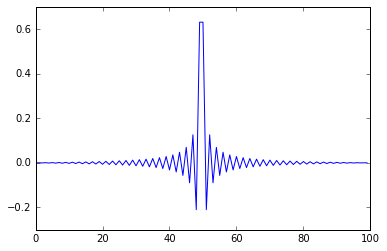

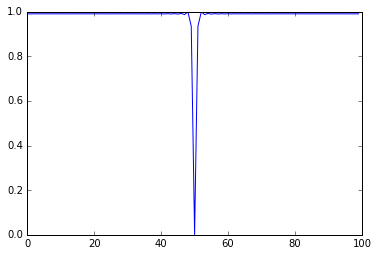

In [57]:
plt.plot(pulse)
plt.show()
plt.plot(abs(np.fft.fft(-pulse)))
plt.show()
plt.show()

Audio(pulse, rate=rate)


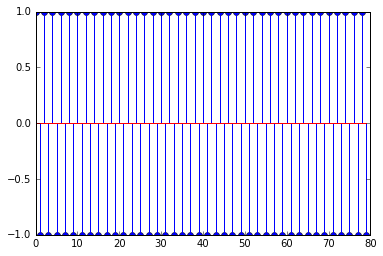

In [58]:
plt.stem(delim)
plt.show()

#### Emitter

In [59]:
d = "The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher gives reading assignments :-)"
len(d)

137

In [60]:
d_bin = binarize(d)
assert d == textarize(d_bin)
d_code = [1 if x == 0 else -1 for x in d_bin]

In [61]:
dt_origin = 756

s_delay = np.zeros(dt_origin)
s_delim = signal(delim, pulse)
s_data = signal(d_code, pulse)

s = np.concatenate((s_delay, s_delim, s_data))

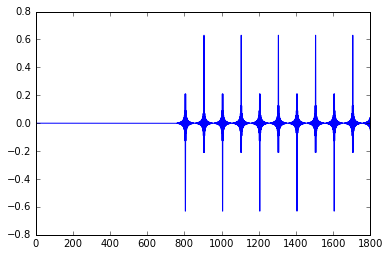

In [62]:
plt.plot(s[0:1800])
plt.show()

In [63]:
Audio(s_data, rate=rate)

#### Channel

In [64]:
c_rate, c = wavfile.read("interference.wav")
assert rate == c_rate
Audio(c, rate=rate)

In [65]:
c_mean = np.mean(c)
c_std = np.std(c)
s_ampl = c_std 
print(c_std)

23992.1804031


32767
15119.2541273


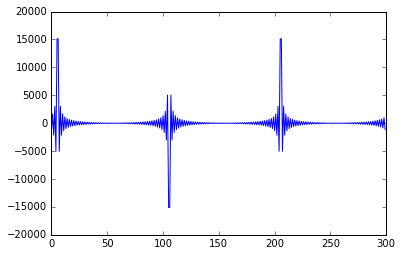

In [66]:
s_n = s[:len(s)] * s_ampl 
plt.plot(s_n[900:1200])
print(max(c[:]))
print(max(s[:] * c_std))
Audio(s_n, rate=rate)

In [67]:
sn = s_n


#### Receiver

In [68]:
xcorr = np.correlate(sn, s_delim)
dt_delay = np.argmax(xcorr)
print(dt_delay)
dt_delay = 756

756


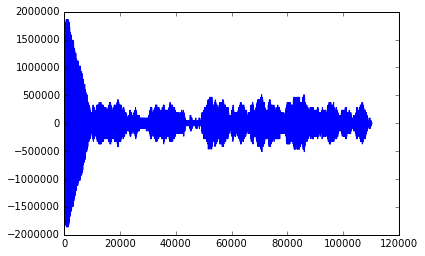

In [69]:
plt.plot(xcorr)
plt.show()

[-23234.701696  23234.701696 -23234.701696 ..., -23234.701696 -23234.701696
  23234.701696]


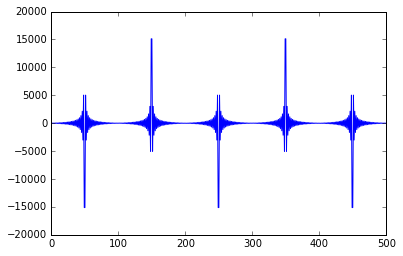

In [98]:
r_shift = sn[dt_delay:]
plt.plot(r_shift[0:500])
r_align = match_decoder(r_shift, pulse, dt_sampling, lambda x: -1 if x < 0 else 1, dt_sampling - 1)
r_code = r_align[len(delim):]

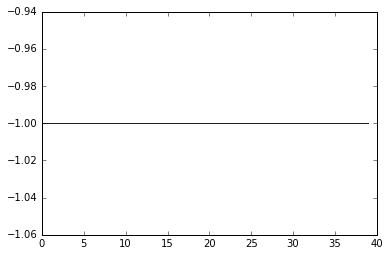

In [71]:
plt.plot(r_code[0:40])
plt.show()

In [72]:
r = [0 if x == 1 else 1 for x in r_code]

r_str = textarize(r[:])
print(len(r_str))
print(d)
print(len(d))
print(r_str)

#print(r[1:25])

#for i in range(0, 1000):
    #print(d_bin[i], ' ', r[i])

#plt.plot(np.correlate(r, d_bin))
#plt.show()

137
The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher gives reading assignments :-)
137
ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿ


In [73]:
def longest_common_substring(s1, s2):
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

t1 = "".join([str(c) for c in d_bin])
t2 = "".join([str(c) for c in r])
longest_common_substring(t1, t2)



'1111'

#### Record

In [74]:
ex_chunk = 1024
ex_format = pyaudio.paInt32
ex_channel = 2
ex_sec = 15

p = pyaudio.PyAudio()
stream = p.open(format=ex_format, channels=ex_channel, rate=rate, input=True, frames_per_buffer=ex_chunk)
buf = []

for i in range(0, int(rate / ex_chunk * ex_sec)):
    data = stream.read(ex_chunk)
    buf.append(np.fromstring(data, 'Int32'))

stream.stop_stream()
stream.close()
p.terminate()

ex_chan = np.array(buf).flatten()
ex_group = np.reshape(ex_chan, [len(ex_chan) / ex_channel, ex_channel])
ex = [np.average(g) for g in ex_group]
assert len(ex) == len(ex_chan) / ex_channel

In [75]:
Audio(ex, rate=rate)

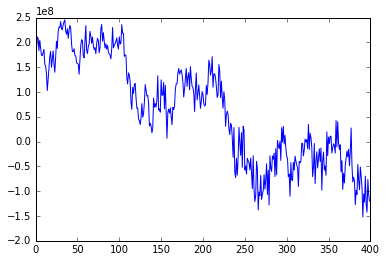

In [76]:
plt.plot(ex[3000:3400])
plt.show()

In [77]:
sn = ex

#### Todos

- amplitude bounds (100Hz - 20KHz)
- mean noise subtraction
- find best amplitude
- lowerpass match
- block with parity checks


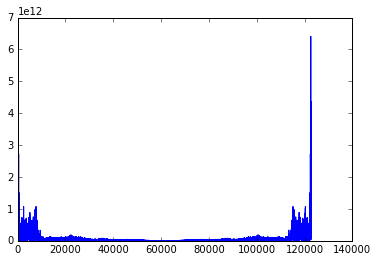

In [78]:
plt.plot(abs(np.fft.fft(ex)))
plt.show()

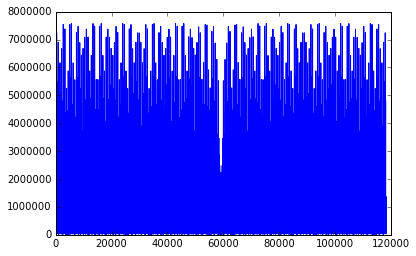

In [79]:
plt.plot(abs(np.fft.fft(s_n)))
plt.show()

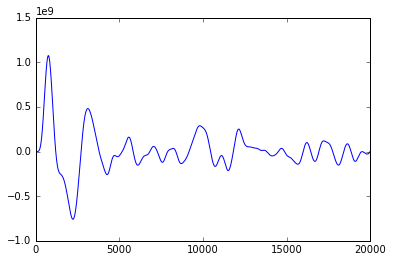

In [80]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

cutoff = 10
order = 6

b, a = butter_lowpass(cutoff, rate, order)
y = lfilter(b, a, ex)
plt.plot(y[0:20000])
plt.show()

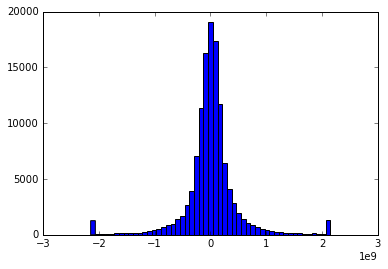

In [81]:
plt.hist(ex, bins=51)
sn = s_n
plt.show()

In [82]:
min(ex)

-2147483648.0

In [83]:
max(ex)

2147483647.0

In [84]:
np.average(ex)

5674415.2840169268

In [85]:
np.average(s_n)

-19.267713077746699

In [86]:
t = signal(delim + 2, pulse)
Audio(t, rate=rate)

In [87]:
delim

array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
       -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
        1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
       -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
        1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
       -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
        1., -1.])

In [88]:
T = 10
t = np.linspace(0, T, int(T * rate))
s_440 = np.sin(2 * np.pi * 440 * t)
s_261 = np.sin(2 * np.pi * 261.63 * t)

In [89]:
Audio(s_440, rate=rate)

In [90]:
Audio(s_261, rate=rate)

In [91]:
s_mix = s_440 * 1000 + s_261 * 500
Audio(s_mix, rate=rate)

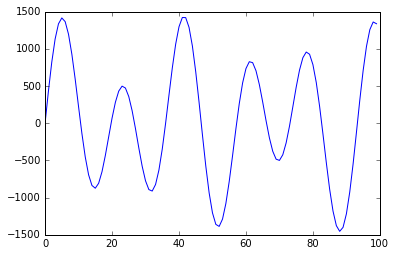

In [92]:
plt.plot(s_mix[:100])

In [93]:
def record(sec, rate):
    ex_chunk = 1024
    ex_format = pyaudio.paInt32
    ex_channel = 2

    p = pyaudio.PyAudio()
    stream = p.open(format=ex_format, channels=ex_channel, rate=rate, input=True, frames_per_buffer=ex_chunk)
    buf = []

    for i in range(0, int(rate / ex_chunk * sec)):
        data = stream.read(ex_chunk)
        buf.append(np.fromstring(data, 'Int32'))

    stream.stop_stream()
    stream.close()
    p.terminate()

    ex_chan = np.array(buf).flatten()
    ex_group = np.reshape(ex_chan, [len(ex_chan) / ex_channel, ex_channel])
    ex = [np.average(g) for g in ex_group]
    assert len(ex) == len(ex_chan) / ex_channel
    
    return ex

In [94]:
recorded = record(5, rate)

In [95]:
Audio(recorded, rate=rate)

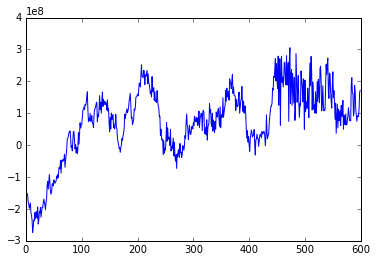

In [96]:
plt.plot(recorded[900:1500])

[-46469.403392  46469.403392 -46469.403392 ..., -46469.403392 -46469.403392
  46469.403392]


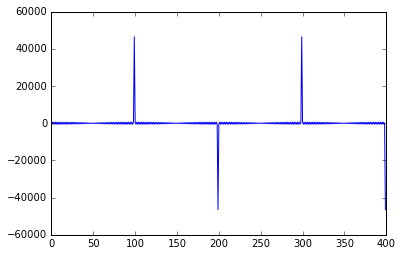

In [97]:
match = np.convolve(r_shift, 2*pulse[::-1])
plt.plot(match[100:500])
print(match[99::100])